___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

___
## Parsing predownloaded pbf maps

In [15]:
import geopandas
from pyrosm import OSM

In [16]:
osm = OSM("data/valuevo.osm.pbf") #possible use of boundary_box parameter and download whole world
natural = osm.get_natural()

[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

<AxesSubplot:>

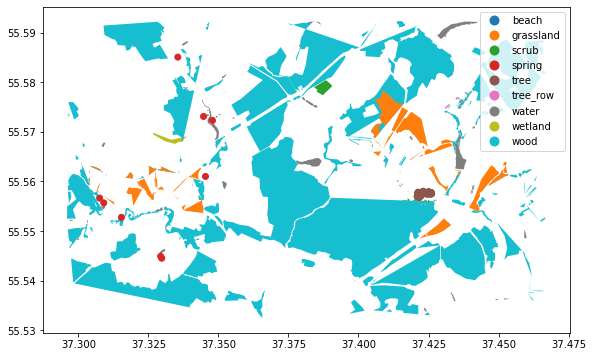

In [17]:
natural = osm.get_natural()
natural.plot(column='natural', legend=True, figsize=(10,6))

In [18]:
natural.head(2)

,changeset,id,tags,lon,version,lat,timestamp,natural,geometry,osm_type,water,wetland
0,0.0,1397359394,None,37.344685,0,55.573128,0,spring,POINT (37.34468 55.57313),node,NaN,NaN
1,0.0,1402253569,"{""name"":""\u041C\u0430\u043B\u0435\u043D\u044C\...",37.347870,0,55.572300,0,spring,POINT (37.34787 55.57230),node,NaN,NaN


In [19]:
natural.geometry.type.unique()

array(['Point', 'Polygon', 'LineString', 'MultiLineString',
       'MultiPolygon'], dtype=object)

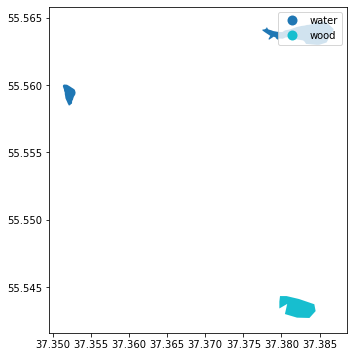

In [89]:
polygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'Polygon'].head(3)
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Building a convex hull

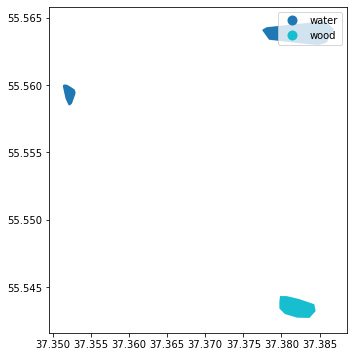

In [90]:
polygons.geometry = polygons.geometry.convex_hull #check for efficiency and rewrite if needed
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Find optimal pair

In [52]:
import numpy as np
import math

def vec(a, b):
    return np.array(b) - np.array(a)

def mod(v):
    return (v[0]**2 + v[1]**2)**0.5

def point_in_angle(p, a, b, c):
    delta = 0.00000001
    return math.fabs(math.acos(np.dot(vec(b,a), vec(b,c))/(mod(vec(b, a)) * mod(vec(b,c)))) - \
        math.acos(np.dot(vec(b,a), vec(b,p))/(mod(vec(b,a)) * mod(vec(b,p)))) - \
        math.acos(np.dot(vec(b,p), vec(b,c))/(mod(vec(b,p)) * mod(vec(b,c))))) < delta

def find_pair(point, left_border, right_border, coord):
    n = len(coord) - 1
    # optimize list work
    b = [1 for i in range(n)]
    count = 0
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            b[i] = 0
            count += 1
    if count == 0:
        return 1
    if count == n:
        print("Point inside a polygon")
        return 0
    if b[0] == 1:
        start = b.index(0, 1)
        if b[n-1] == 0:
            end = n-1
        else:
            end = b.index(1, start + 1)
            end -= 1
    if b[0] == 0:
        start = b.index(1, 1)
        start -= 1
        if b[n-1] == 1:
            end = n
        else:
            end = b.index(0, start + 1)
    return (coord[start], coord[end])

In [102]:
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import mplleaflet

poly_number = polygons.shape[0]
fig = plt.figure()

for i in range(poly_number):
    x_arr, y_arr = (polygons.iloc[i,1]).exterior.coords.xy
    plt.plot(x_arr, y_arr);
    coords_1 = mapping(polygons.iloc[i,1])['coordinates'][0]
    for j in range(poly_number):
        if j == i:
            continue
        coords_2 = mapping(polygons.iloc[j,1])['coordinates'][0]
        n = len(coords_2) - 1
        for k in range(n):
            point = coords_2[k%n]
            left_border = coords_2[(k-1)%n]
            right_border = coords_2[(k+1)%n]
            pair = find_pair(point, left_border, right_border, coords_1)
            if pair == 1:
                continue
            pair_x = [point[0], pair[1][0]]
            pair_y = [point[1], pair[1][1]]
            plt.plot(pair_x, pair_y);
            pair_x = [point[0], pair[0][0]]
            pair_y = [point[1], pair[0][1]]
            plt.plot(pair_x, pair_y);

mplleaflet.display(fig=fig)

___
## Graph

In [83]:
from igraph import *

In [57]:
g = Graph()

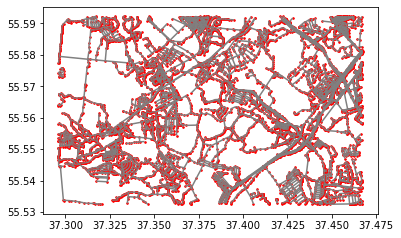

In [79]:
# Read nodes and edges of the 'driving' network
nodes, edges = osm.get_network(nodes=True, network_type="walking") # driving for directed graph

# Plot nodes and edges on a map
ax = edges.plot(figsize=(6,6), color="gray")
ax = nodes.plot(ax=ax, color="red", markersize=2.5)